<a href="https://colab.research.google.com/github/CastanharoA/Page--AMFCorreia/blob/b3_castan/9_Hjorth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%%**********************]  1 of 1 completed


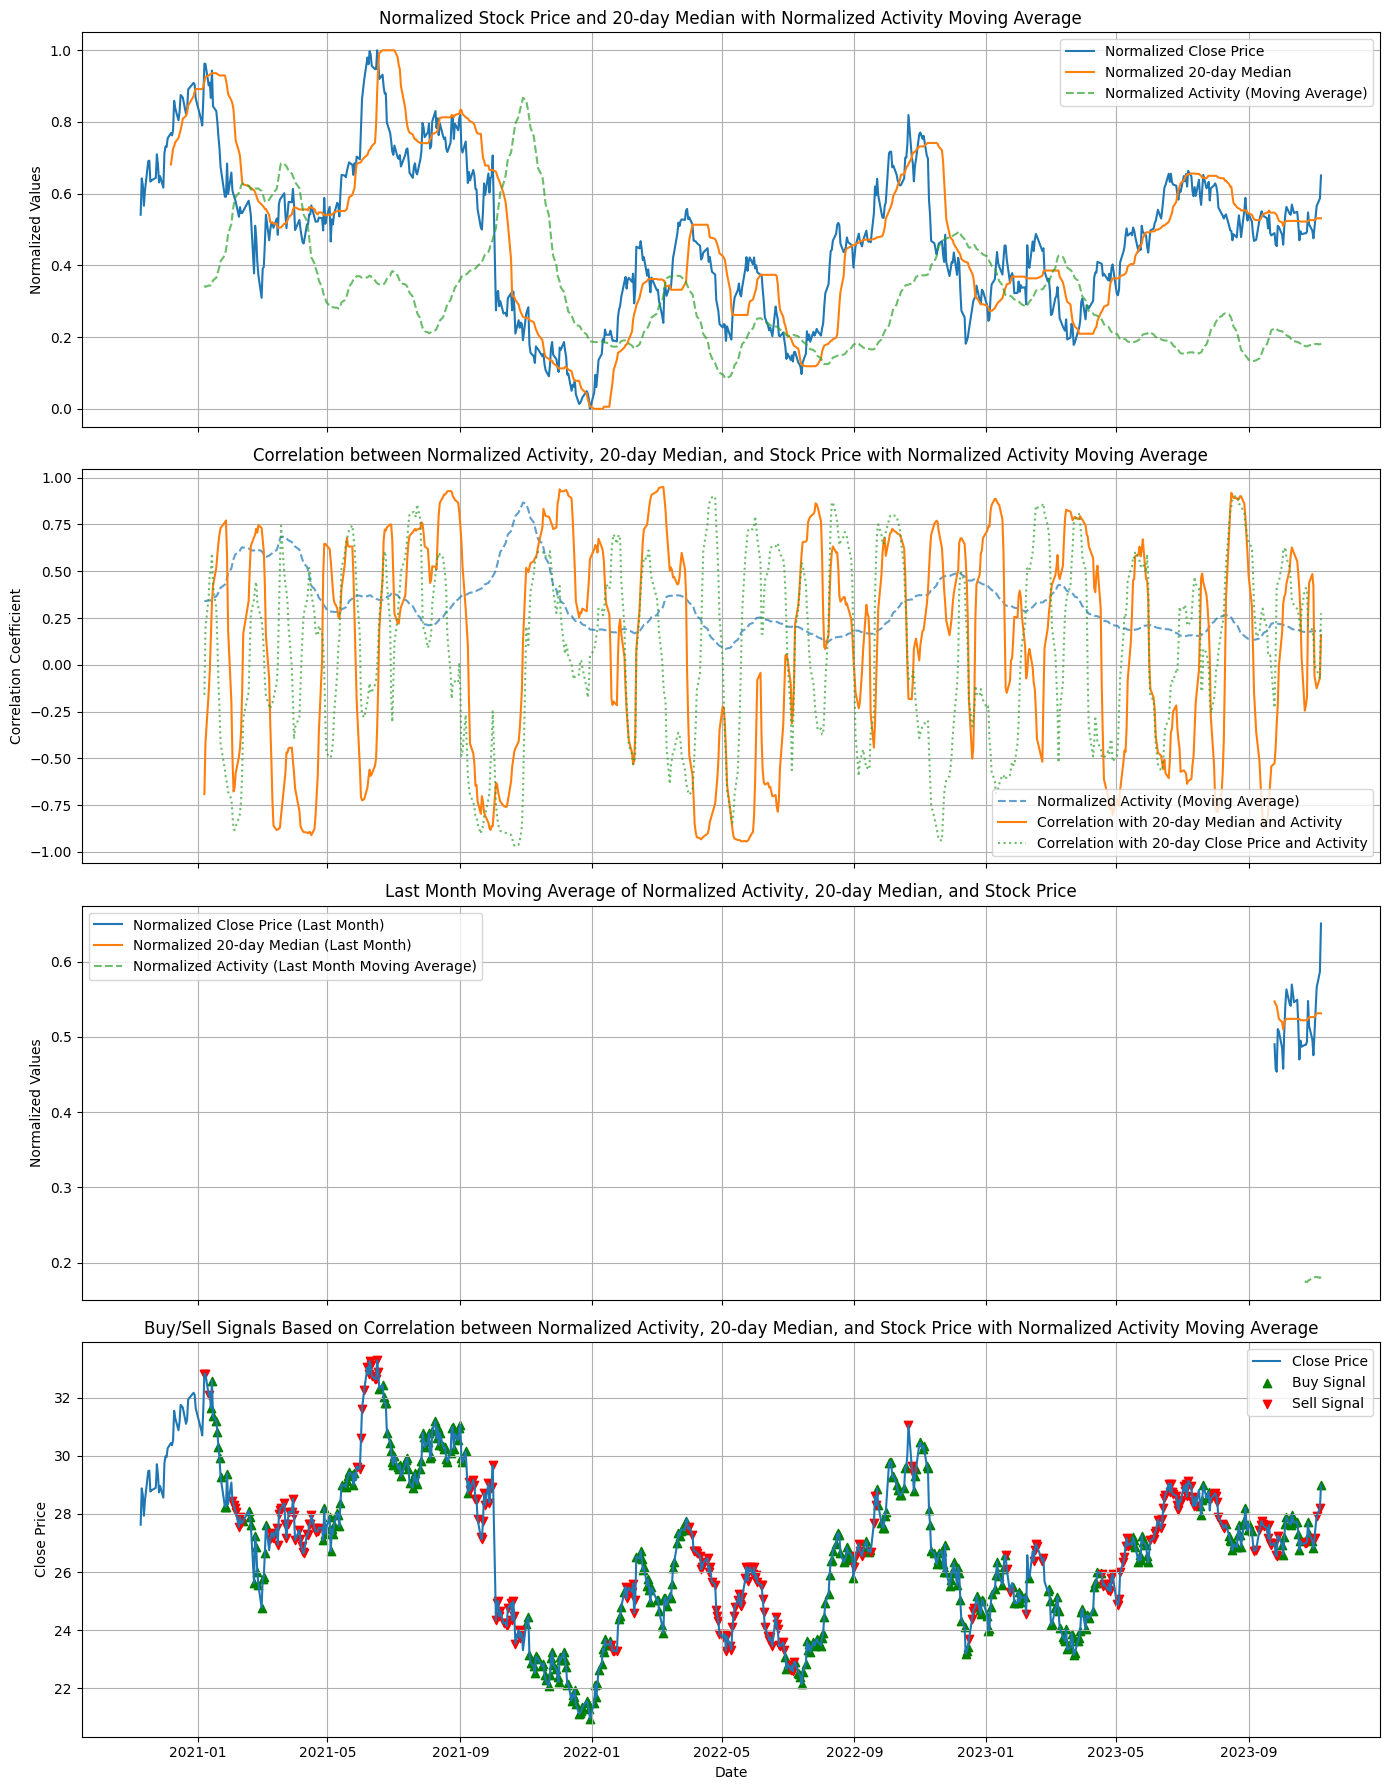

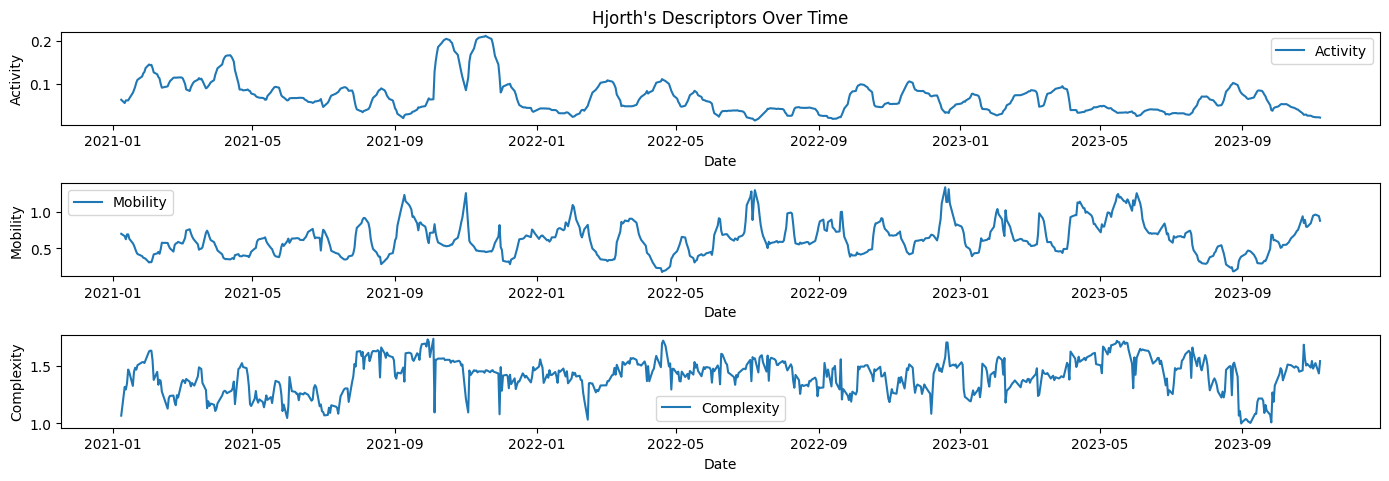

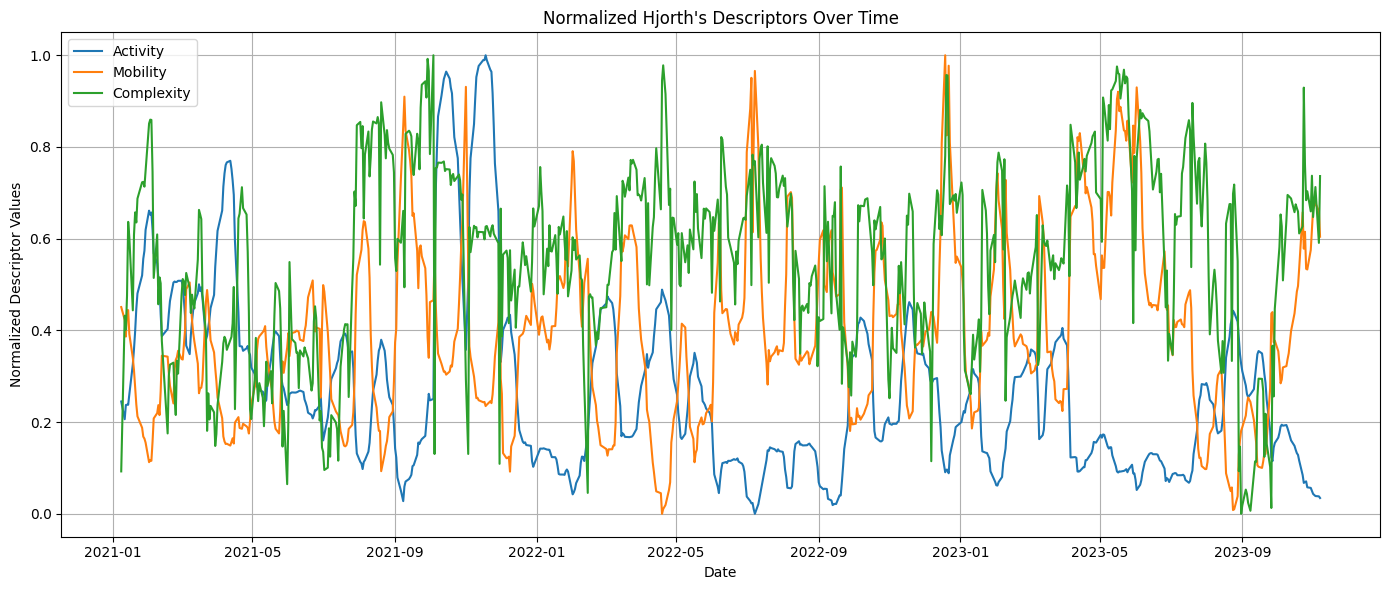


Predictions:
2020-11-09 00:00:00: Hold Signal - Hold your position.
2020-11-10 00:00:00: Hold Signal - Hold your position.
2020-11-11 00:00:00: Hold Signal - Hold your position.
2020-11-12 00:00:00: Hold Signal - Hold your position.
2020-11-13 00:00:00: Hold Signal - Hold your position.
2020-11-16 00:00:00: Hold Signal - Hold your position.
2020-11-17 00:00:00: Hold Signal - Hold your position.
2020-11-18 00:00:00: Hold Signal - Hold your position.
2020-11-19 00:00:00: Hold Signal - Hold your position.
2020-11-23 00:00:00: Hold Signal - Hold your position.
2020-11-24 00:00:00: Hold Signal - Hold your position.
2020-11-25 00:00:00: Hold Signal - Hold your position.
2020-11-26 00:00:00: Hold Signal - Hold your position.
2020-11-27 00:00:00: Hold Signal - Hold your position.
2020-11-30 00:00:00: Hold Signal - Hold your position.
2020-12-01 00:00:00: Hold Signal - Hold your position.
2020-12-02 00:00:00: Hold Signal - Hold your position.
2020-12-03 00:00:00: Hold Signal - Hold your positi

<ipython-input-8-1a1e6f5d84b1>:113: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if patterns[i:i+pattern_length] == [cycle1] * pattern_length and patterns[i+pattern_length] == cycle2:


2021-09-27 00:00:00: Activity=0.0469, Mobility=0.7986, Complexity=1.6943
2021-09-28 00:00:00: Activity=0.0527, Mobility=0.7300, Complexity=1.6683
2021-09-29 00:00:00: Activity=0.0592, Mobility=0.6226, Complexity=1.7305
2021-09-30 00:00:00: Activity=0.0652, Mobility=0.5704, Complexity=1.7109
2021-10-01 00:00:00: Activity=0.0624, Mobility=0.7122, Complexity=1.5775
2021-10-04 00:00:00: Activity=0.0630, Mobility=0.7171, Complexity=1.7362
2021-10-05 00:00:00: Activity=0.1281, Mobility=0.8319, Complexity=1.0956
2021-10-06 00:00:00: Activity=0.1527, Mobility=0.7077, Complexity=1.5550
2021-10-07 00:00:00: Activity=0.1708, Mobility=0.6340, Complexity=1.5558
2021-10-08 00:00:00: Activity=0.1858, Mobility=0.5812, Complexity=1.5638
2021-10-11 00:00:00: Activity=0.1949, Mobility=0.5548, Complexity=1.5634
2021-10-13 00:00:00: Activity=0.2020, Mobility=0.5349, Complexity=1.5656
2021-10-14 00:00:00: Activity=0.2037, Mobility=0.5352, Complexity=1.5503
2021-10-15 00:00:00: Activity=0.2053, Mobility=0.52

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
from scipy.fft import fft
from itertools import groupby

def download_stock_data(ticker, start_date, end_date):
    """Download stock data from Yahoo Finance."""
    data = yf.download(ticker, start_date, end_date)
    return data

def calculate_indicators(data):
    """Calculate the 20-day median and Hjorth's descriptors."""
    data['20_day_median'] = data['Close'].rolling(window=20).median()
    data['activity'] = data['Close'].rolling(window=20).apply(lambda x: np.sum(np.abs(np.diff(x))))
    return data

def hjorth_activity(data):
    """Calculate Hjorth's Descriptors."""
    diff = np.diff(data)
    diff_diff = np.diff(diff)

    var_activity = np.var(data)
    var_diff = np.var(diff)
    var_diff_diff = np.var(diff_diff)

    activity = np.sqrt(var_activity)
    mobility = np.sqrt(var_diff / var_activity)
    complexity = np.sqrt(var_diff_diff / var_diff)

    return activity, mobility, complexity

def normalize_data(data):
    """Normalize the stock data."""
    data_normalized = (data - data.min()) / (data.max() - data.min())
    return data_normalized

def calculate_correlations(data_normalized):
    """Calculate correlations between normalized data."""
    correlation_activity_20 = data_normalized['activity'].rolling(window=20).corr(data_normalized['20_day_median'])
    correlation_price_activity_20 = data_normalized['Close'].rolling(window=20).corr(data_normalized['activity'])
    return correlation_activity_20, correlation_price_activity_20

def generate_dynamic_thresholds(data_normalized):
    """Generate dynamic thresholds based on rolling standard deviation."""
    rolling_std = data_normalized['activity'].rolling(window=20).std()
    buy_threshold = rolling_std * 1.5
    sell_threshold = -rolling_std * 1.5
    return buy_threshold, sell_threshold

def generate_signals(correlation_activity_20, buy_threshold, sell_threshold):
    """Generate buy and sell signals based on correlation values."""
    buy_signals = np.zeros(len(correlation_activity_20))
    sell_signals = np.zeros(len(correlation_activity_20))

    buy_signals[correlation_activity_20 > buy_threshold] = 1
    sell_signals[correlation_activity_20 < sell_threshold] = -1

    return buy_signals, sell_signals

def generate_predictions(buy_signals, sell_signals):
    """Generate predictions based on buy and sell signals."""
    predictions = np.zeros(len(buy_signals))
    predictions[buy_signals == 1] = 1  # Buy prediction
    predictions[sell_signals == -1] = -1  # Sell prediction
    return predictions

def analyze_cycles(predictions):
    cycle_start = None
    patterns = []

    for i in range(len(predictions)):
        if predictions[i] == 1:
            if cycle_start is None:
                cycle_start = i
            elif i - cycle_start >= 6:
                patterns.append('Up Cycle')
                cycle_start = None
        elif predictions[i] == -1:
            if cycle_start is None:
                cycle_start = i
            elif i - cycle_start >= 6:
                patterns.append('Down Cycle')
                cycle_start = None
        else:
            if cycle_start is not None and i - cycle_start >= 2:
                patterns.append('Hold Cycle')
                cycle_start = None

    print("\nCycle Analysis:")

    # Calculate dynamic cycle lengths
    up_cycles_lengths = [len(list(g)) for k, g in groupby(patterns) if k == 'Up Cycle']
    down_cycles_lengths = [len(list(g)) for k, g in groupby(patterns) if k == 'Down Cycle']
    hold_cycles_lengths = [len(list(g)) for k, g in groupby(patterns) if k == 'Hold Cycle']

    print(f"Up Cycles: {up_cycles_lengths}")
    print(f"Down Cycles: {down_cycles_lengths}")
    print(f"Hold Cycles: {hold_cycles_lengths}")

    # Analyze patterns between cycles
    patterns_up_to_down = analyze_pattern_between_cycles(patterns, 'Up Cycle', 'Down Cycle', 3)

    print("\nPatterns in Cycles:")
    pattern_counts = {k: len(list(g)) for k, g in groupby(patterns)}
    for pattern, count in pattern_counts.items():
        print(f"{count} cycles of {pattern}.")

def analyze_pattern_between_cycles(patterns, cycle1, cycle2, pattern_length):
    pattern_occurrences = []
    for i in range(len(patterns) - pattern_length):
        if patterns[i:i+pattern_length] == [cycle1] * pattern_length and patterns[i+pattern_length] == cycle2:
            pattern_occurrences.append(patterns[i:i+pattern_length+1])
    return pattern_occurrences

def plot_data_and_signals(data, data_normalized, correlation_activity_20, correlation_price_activity_20, buy_signals, sell_signals, predictions):
    """Plot stock data along with buy and sell signals."""
    fig, axes = plt.subplots(4, 1, figsize=(14, 18), sharex=True)

    # Plot normalized data
    axes[0].plot(data_normalized['Close'], label='Normalized Close Price')
    axes[0].plot(data_normalized['20_day_median'], label='Normalized 20-day Median')
    axes[0].plot(data_normalized['activity'].rolling(window=20).mean(), label='Normalized Activity (Moving Average)', linestyle='--', alpha=0.7)
    axes[0].set_title('Normalized Stock Price and 20-day Median with Normalized Activity Moving Average')
    axes[0].set_ylabel('Normalized Values')
    axes[0].legend()
    axes[0].grid(True)

    # Plot correlations
    axes[1].plot(data_normalized['activity'].rolling(window=20).mean(), label='Normalized Activity (Moving Average)', linestyle='--', alpha=0.7)
    axes[1].plot(correlation_activity_20, label='Correlation with 20-day Median and Activity')
    axes[1].plot(correlation_price_activity_20, label='Correlation with 20-day Close Price and Activity', linestyle=':', alpha=0.7)
    axes[1].set_title('Correlation between Normalized Activity, 20-day Median, and Stock Price with Normalized Activity Moving Average')
    axes[1].set_ylabel('Correlation Coefficient')
    axes[1].legend()
    axes[1].grid(True)

    # Plot last month's data
    last_month_data = data.iloc[-30:]
    last_month_normalized = data_normalized.iloc[-30:]
    axes[2].plot(last_month_normalized['Close'], label='Normalized Close Price (Last Month)')
    axes[2].plot(last_month_normalized['20_day_median'], label='Normalized 20-day Median (Last Month)')
    axes[2].plot(last_month_normalized['activity'].rolling(window=20).mean(), label='Normalized Activity (Last Month Moving Average)', linestyle='--', alpha=0.7)
    axes[2].set_title('Last Month Moving Average of Normalized Activity, 20-day Median, and Stock Price')
    axes[2].set_ylabel('Normalized Values')
    axes[2].legend()
    axes[2].grid(True)

    # Plot signals along with stock price
    axes[3].plot(data['Close'], label='Close Price')
    axes[3].scatter(data.index[buy_signals == 1], data['Close'][buy_signals == 1], marker='^', color='g', label='Buy Signal')
    axes[3].scatter(data.index[sell_signals == -1], data['Close'][sell_signals == -1], marker='v', color='r', label='Sell Signal')
    axes[3].set_title('Buy/Sell Signals Based on Correlation between Normalized Activity, 20-day Median, and Stock Price with Normalized Activity Moving Average')
    axes[3].set_xlabel('Date')
    axes[3].set_ylabel('Close Price')
    axes[3].legend()
    axes[3].grid(True)

    plt.tight_layout()
    plt.show()

def find_cycles(data_normalized):
    """Find cycles in Hjorth's Descriptors."""
    activity, mobility, complexity = zip(*[hjorth_activity(data_normalized['activity'].values[i-20:i]) for i in range(20, len(data_normalized))])

    plt.figure(figsize=(14, 6))

    plt.subplot(4, 1, 1)
    plt.plot(data_normalized.index[20:], activity, label='Activity')
    plt.title("Hjorth's Descriptors Over Time")
    plt.xlabel('Date')
    plt.ylabel('Activity')
    plt.legend()

    plt.subplot(4, 1, 2)
    plt.plot(data_normalized.index[20:], mobility, label='Mobility')
    plt.xlabel('Date')
    plt.ylabel('Mobility')
    plt.legend()

    plt.subplot(4, 1, 3)
    plt.plot(data_normalized.index[20:], complexity, label='Complexity')
    plt.xlabel('Date')
    plt.ylabel('Complexity')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_hjorth_descriptors(data_normalized):
    """Plot normalized Hjorth's Descriptors over time."""
    hjorth_data = []

    for i in range(20, len(data_normalized)):
        activity, mobility, complexity = hjorth_activity(data_normalized['activity'].values[i-20:i])
        hjorth_data.append((activity, mobility, complexity))

    hjorth_df = pd.DataFrame(hjorth_data, columns=['Activity', 'Mobility', 'Complexity'], index=data_normalized.index[20:])

    # Normalize Hjorth's Descriptors
    hjorth_df_normalized = (hjorth_df - hjorth_df.min()) / (hjorth_df.max() - hjorth_df.min())

    # Plot normalized Hjorth's Descriptors in a single plot
    fig, ax = plt.subplots(figsize=(14, 6))  # Set the desired figsize

    ax.plot(hjorth_df_normalized.index, hjorth_df_normalized['Activity'], label='Activity')
    ax.plot(hjorth_df_normalized.index, hjorth_df_normalized['Mobility'], label='Mobility')
    ax.plot(hjorth_df_normalized.index, hjorth_df_normalized['Complexity'], label='Complexity')

    plt.title("Normalized Hjorth's Descriptors Over Time")
    plt.xlabel('Date')
    plt.ylabel('Normalized Descriptor Values')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def main():
    # Step 1: Download data
    data = download_stock_data('ITUB4.SA', '2020-11-08', '2023-11-08')

    # Step 2: Calculate indicators
    data = calculate_indicators(data)

    # Step 3: Normalize data
    data_normalized = normalize_data(data)

    # Step 4: Calculate correlations
    correlation_activity_20, correlation_price_activity_20 = calculate_correlations(data_normalized)

    # Step 5: Generate dynamic thresholds
    buy_threshold, sell_threshold = generate_dynamic_thresholds(data_normalized)

    # Step 6: Generate signals with dynamic thresholds
    buy_signals, sell_signals = generate_signals(correlation_activity_20, buy_threshold, sell_threshold)

    # Step 6.1: Generate predictions
    predictions = generate_predictions(buy_signals, sell_signals)

    # Step 7: Plot data and signals
    plot_data_and_signals(data, data_normalized, correlation_activity_20, correlation_price_activity_20, buy_signals, sell_signals, predictions)

    # Step 8: Find cycles in Hjorth's Descriptors
    find_cycles(data_normalized)

    # Step 8.1: Plot Hjorth's Descriptors separately
    plot_hjorth_descriptors(data_normalized)

    # Step 9: Print predictions and analyze cycles
    print("\nPredictions:")
    for i in range(len(data)):
        date = data.index[i]
        prediction = predictions[i]

        if prediction == 1:
            print(f"{date}: Buy Signal - Consider buying.")
        elif prediction == -1:
            print(f"{date}: Sell Signal - Consider selling.")
        else:
            print(f"{date}: Hold Signal - Hold your position.")

    # Step 9.1: Analyze cycles
    analyze_cycles(predictions)

    # Step 9.2: Analyze patterns between cycles
    patterns_between_cycles = analyze_pattern_between_cycles(predictions, 'Up Cycle', 'Down Cycle', 3)

    print("\nPatterns Between Cycles:")
    for pattern in patterns_between_cycles:
        print(f"Pattern: {pattern}")

    # Step 10: Print Hjorth's Descriptors
    print("\nHjorth's Descriptors Over Time:")
    for i in range(20, len(data_normalized)):
        date = data_normalized.index[i]
        activity, mobility, complexity = hjorth_activity(data_normalized['activity'].values[i-20:i])
        print(f"{date}: Activity={activity:.4f}, Mobility={mobility:.4f}, Complexity={complexity:.4f}")

if __name__ == "__main__":
    main()